### Do the required imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt


### Calibrate the camera
Here I collect the image points and the object points from the calibration images. These points are later used for camera calibration.

In [2]:
# number of corners along the x and y axes
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


In the above step I got the image points and object points. Here I pass them to `cv2.calibrateCamera()` to get the distortion matrix `mtx` and the distortion cofficients `dist`. Now I can use `cv2.undistort()` to undistort any image taken from the same camera. 

Note: `mtx` and `dist` are camera specific values and it will be different for every camera.

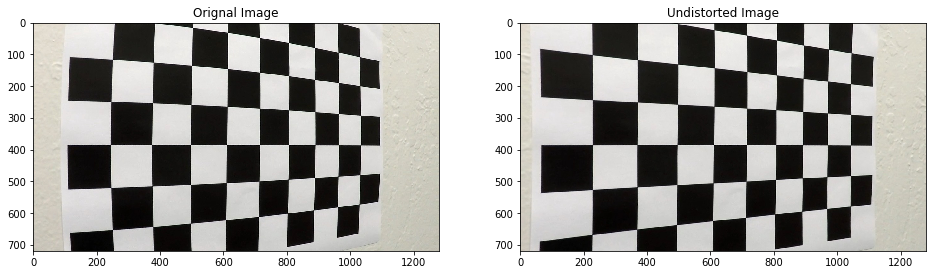

In [3]:
# undistort a test image
img = mpimg.imread('./camera_cal/test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
u_img = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.imshow(img)
ax1.set_title('Orignal Image')
ax2.imshow(u_img)
ax2.set_title('Undistorted Image')

At this point I am done with the camera calibration process.


### Building up the pipeline

Here I build and test all the necessary functions that make up my video processing pipeline. 

The first step of the pipeline would be to undistort the input image. For this I define a function `undistort`.

In [4]:
# this function takes an image and returns undistorted image
def undistort(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

Here I test my `undistort` function over a image.

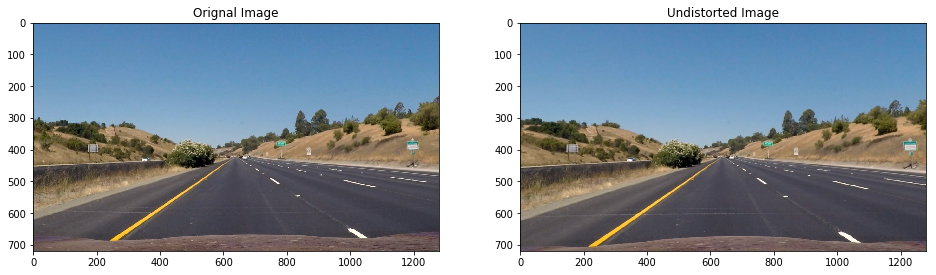

In [5]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
u_img = undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(img)
ax1.set_title('Orignal Image')
ax2.imshow(u_img)
ax2.set_title('Undistorted Image')
mpimg.imsave('straight_lines1_undistorted.jpg',u_img)

After Undistorting the image I defined 3 functions to extract the lane markings.

`hls_select` - extracts the s channel and converts it to binary.

`gradient_select` - takes a gradient along x axis and converts the resulting image to binary.

`add_binary` - combines both the binary images into a single image.

In [6]:
def hls_select(img, thresh=(60,250)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>thresh[0]) & (s_channel<thresh[1])] = 1
    return s_binary

def gradient_select(img, thresh=(30,250)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=17)
    abs_sob = np.absolute(sobelx)
    scaled_sob = np.uint8(abs_sob/np.max(abs_sob)*255)
    sxbinary = np.zeros_like(sobelx)
    sxbinary[(scaled_sob>thresh[0]) & (scaled_sob<thresh[1])] = 1
    return sxbinary

def add_binary(b1, b2):
    combined_binary = np.zeros_like(b1)
    combined_binary[(b1==1) | (b2==1)] = 1
    return combined_binary

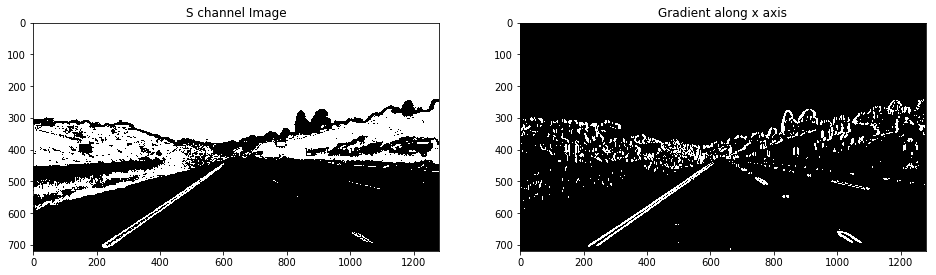

In [7]:
s_binary = hls_select(u_img,(60,250))
sxbinary = gradient_select(u_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(s_binary, cmap='gray')
ax1.set_title('S channel Image')
ax2.imshow(sxbinary, cmap='gray')
ax2.set_title('Gradient along x axis')

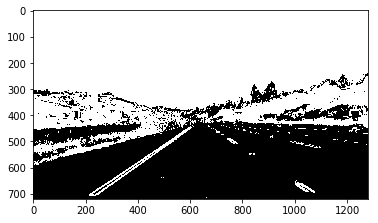

In [8]:
combined_binary = add_binary(s_binary, sxbinary)
plt.imshow(combined_binary, cmap='gray')

Now I need to change the perspective of the image so as to get a top down view of the road. This will show the lane lines parallel to each other.

For this I will create a source array `src` and a destination array `dst` and pass them to `cv2.getPerspectiveTransform()` to get the transformation matrix `M`

In [9]:
# src = np.float32([[180,660], [560,460], [720,460], [1130,660]])
# dst = np.float32([[200,719], [200,0], [979,0], [979,719]])
src = np.float32([[200,720], [600, 447], [679,447], [1100,720]])
dst = np.float32([[300, 720], [300, 0], [900, 0], [900, 720]])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = cv2.getPerspectiveTransform(dst, src)
img_size = (u_img.shape[1], u_img.shape[0])
def warp(image, M):
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

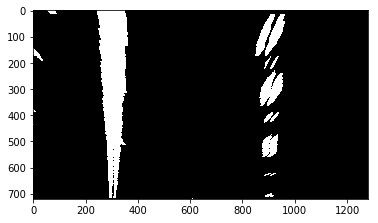

In [10]:
warped = warp(combined_binary, M)
plt.imshow(warped, cmap='gray')

Now that I have got the top down view of the road as a binary image I need to find out which pixels make up the lane lines and which don't. To search for the lane lines I have created a function `sliding_window()` which scans the binary image to find both the right and left lane. 
Once I have found the lanes, in the next image frame I don't need to search the entire image again to get the lanes. Instead I can just search around the lane area I found in the previous frame. To do this I define another function `search_in_margin()`. In order for this to work I needed some data from the `sliding_window()`. 

To keep the data and the functionality together I defined a class called `Line()` and defined both the functions inside this class. Now the class holds the data for the lanes and also the functions which use this data.

In [11]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        
        self.left_fit = None
        self.right_fit = None
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_left = None  
        self.best_fit_right = None 
        
        # store the cofficient for last 10 frames
        self.avg_left = np.array([])
        self.avg_right = np.array([])
        
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def __perform_average(self):
        self.avg_left = np.append(self.avg_left, mylines.left_fit)
        self.avg_right = np.append(self.avg_right, mylines.right_fit)
        
        self.avg_left = np.reshape(self.avg_left,(-1,3))
        self.avg_right = np.reshape(self.avg_right,(-1,3))
        
        self.avg_left = self.avg_left[-10:]
        self.avg_right = self.avg_right[-10:]
        
        self.best_fit_left = np.sum(self.avg_left,axis=0) / self.avg_left.shape[0]
        self.best_fit_right = np.sum(self.avg_right,axis=0) / self.avg_right.shape[0]
        
    def sliding_window(self, binary_warped, out_img):
        # clear previous values of class variables 
        self.__init__()
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#         plt.plot(histogram)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
#             cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
#             cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
#         print(len(left_lane_inds))
#         print(len(right_lane_inds))

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
             
        # Fit a second order polynomial to each
        mylines.left_fit = np.polyfit(lefty, leftx, 2)
        mylines.right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = mylines.left_fit[0]*ploty**2 + mylines.left_fit[1]*ploty + mylines.left_fit[2]
        right_fitx = mylines.right_fit[0]*ploty**2 + mylines.right_fit[1]*ploty + mylines.right_fit[2]
        
        mylines.detected = True
        
        return left_fitx, right_fitx, ploty
    
    def search_in_margin(self, binary_warped, out_img):
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        self.__perform_average()
        left_lane_inds = ((nonzerox > (mylines.best_fit_left[0]*(nonzeroy**2) + mylines.best_fit_left[1]*nonzeroy + 
        mylines.best_fit_left[2] - margin)) & (nonzerox < (mylines.best_fit_left[0]*(nonzeroy**2) + 
        mylines.best_fit_left[1]*nonzeroy + mylines.best_fit_left[2] + margin))) 

        right_lane_inds = ((nonzerox > (mylines.best_fit_right[0]*(nonzeroy**2) + mylines.best_fit_right[1]*nonzeroy + 
        mylines.best_fit_right[2] - margin)) & (nonzerox < (mylines.best_fit_right[0]*(nonzeroy**2) + 
        mylines.best_fit_right[1]*nonzeroy + mylines.best_fit_right[2] + margin)))  
        
        if len(left_lane_inds) < 10000 or len(right_lane_inds) < 10000:
            mylines.detected = False
            left_fitx, right_fitx, ploty = self.sliding_window(binary_warped)
            
            return left_fitx, right_fitx, ploty
        
        else:
            # extract left and right line pixel positions
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds] 
            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            # Fit a second order polynomial to each
            mylines.left_fit = np.polyfit(lefty, leftx, 2)
            mylines.right_fit = np.polyfit(righty, rightx, 2)
            
            self.__perform_average()
            
            # Generate x and y values for plotting
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
            left_fitx = mylines.left_fit[0]*ploty**2 + mylines.left_fit[1]*ploty + mylines.left_fit[2]
            right_fitx = mylines.right_fit[0]*ploty**2 + mylines.right_fit[1]*ploty + mylines.right_fit[2]
            

            return left_fitx, right_fitx, ploty

In [12]:
mylines = Line()
    
def find_lines(binary_warped):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    if mylines.detected == False:
        left_fitx, right_fitx, ploty = mylines.sliding_window(binary_warped, out_img)
    
    else:
        left_fitx, right_fitx, ploty = mylines.search_in_margin(binary_warped, out_img)
        
    
    window_img = np.zeros_like(out_img)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+4*margin, ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-4*margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    lane_pts = np.hstack((left_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#     plt.imshow(result)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    
    return window_img

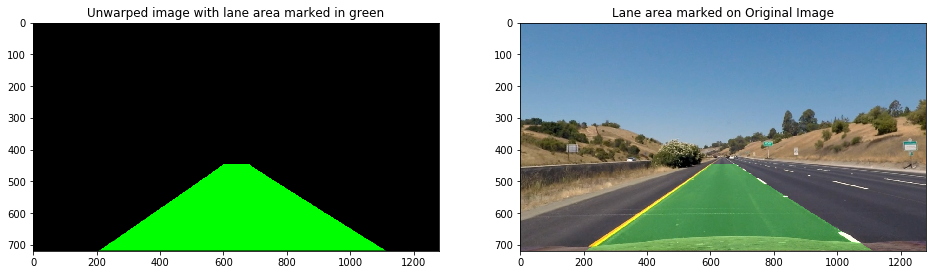

In [13]:
marked_binary = find_lines(warped)
unwarped = warp(marked_binary, M_inv)
final_img = cv2.addWeighted(u_img, 1, unwarped, 0.3, 0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(unwarped)
ax1.set_title('Unwarped image with lane area marked in green')
ax2.imshow(final_img)
ax2.set_title('Lane area marked on Original Image')

In [14]:

def pipeline(image):
    img = undistort(image, mtx, dist)
    b1 = hls_select(img)
    b2 = gradient_select(img)
    cb = add_binary(b1, b2)
    warped = warp(cb, M)
    
    marked_binary = find_lines(warped)
    unwarped = warp(marked_binary, M_inv)
    final = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    return final

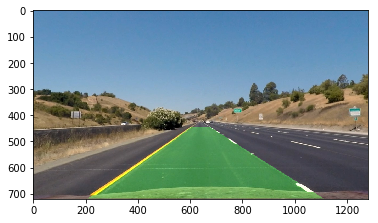

In [15]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
final = pipeline(img)
plt.imshow(final)

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

# create a folder to store the output video
if(not(os.path.exists("./test_videos_output"))):
    os.mkdir("test_videos_output/")
mylines = Line()    
video_output = 'test_videos_output/output_video_4.mp4'

clip1 = VideoFileClip("./project_video.mp4")
processed_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/output_video_4.mp4
[MoviePy] Writing video test_videos_output/output_video_4.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:34<00:00,  6.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output_video_4.mp4 

Wall time: 3min 37s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [18]:
mylines = Line()    
video_output = 'test_videos_output/challenge_video_1.mp4'

clip2 = VideoFileClip("./challenge_video.mp4")
processed_clip2 = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time processed_clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video_1.mp4
[MoviePy] Writing video test_videos_output/challenge_video_1.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:26<00:00,  6.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video_1.mp4 

Wall time: 1min 29s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))